# <font color='blue'>Projeto de Algoritmo Para Classificação de Imagens e Identificação de Material Reciclável</font>


## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.10.12


In [2]:
# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.4 MB/s eta 0:00:00


https://pytorch.org/vision/stable/index.html

In [3]:
# Imports
import os
import io
import time
import torch
import numpy as np
import pandas as pd
import pickle
import urllib.request
import random
import gdown
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.models import resnet18, ResNet18_Weights, resnet152, ResNet152_Weights
%matplotlib inline

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Projeto" --iversions

Author: Projeto

torchvision: 0.16.0+cu118
numpy      : 1.23.5
gdown      : 4.6.6
PIL        : 9.4.0
torch      : 2.1.0+cu118
matplotlib : 3.7.1
pandas     : 1.5.3



## Carregando o Conjunto de Dados

**O conjunto de dados de classificação de material reciclável contém 6 grupos de imagens:**

* cardboard
* glass
* metal
* paper
* plastic
* trash

Cada grupo será uma classe em nosso modelo.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Pasta com as imagens
data_dir = Path('/content/drive/MyDrive/imagens/15-Projeto3/dados/')

In [7]:
# Transformação
transformador = T.Compose([T.Resize((256, 256)), T.ToTensor()])

In [8]:
# Carrega as imagens a aplica as transformações
dataset = ImageFolder(data_dir, transform = transformador)

In [9]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [10]:
# Classes das imagens
print(dataset.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


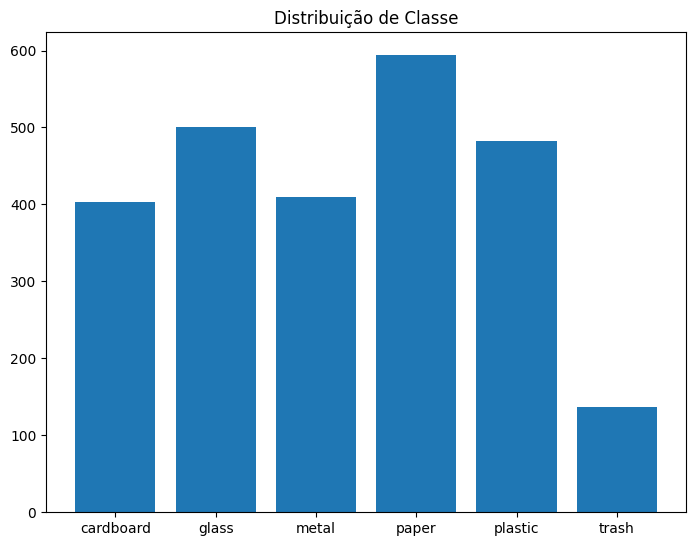

In [11]:
# Plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
counts = [403,501,410,594,482,137]
ax.bar(dataset.classes, counts)
plt.title('Distribuição de Classe')
plt.show()

## Preparação das Imagens

In [12]:
# Função de split (divisão 90/5/5)
def split(length) -> tuple:
    r = .05
    test_val = int(round(length*r,0))
    train = int(round(length-test_val*2,0))
    return (train,test_val,test_val)

In [13]:
# Split randômico das imagens
dados_treino, dados_teste, dados_valid = random_split(dataset, split(len(dataset)),
                                                      generator = torch.Generator().manual_seed(42))

In [14]:
print(f'Splits: {(len(dados_treino),len(dados_teste),len(dados_valid))}')

Splits: (2275, 126, 126)


In [15]:
# Tamanho do batch
batch_size = 16

Um DataLoader no PyTorch permite o carregamento de dados de treinamento em pequenos pacotes (lotes) durante o treinamento de modelos de aprendizado profundo.

É uma camada de abstração sobre a fonte de dados (por exemplo, um conjunto de dados em disco) que facilita o acesso aos dados e permite a configuração de diferentes tipos de comportamentos como o embaralhamento dos dados, o uso de vários processos de subprocessamento, etc.

Além disso, o DataLoader também permite que você trabalhe com datasets de tamanho maior do que a memória do seu dispositivo, pois ele permite que você carregue os dados em pedaços (lotes) durante o treinamento.

In [16]:
# Data Loader de treino
dl_treino = DataLoader(dataset = dados_treino,
                       batch_size = batch_size,
                       shuffle = True,
                       num_workers = 4,
                       pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
# Data Loader de teste
dl_teste = DataLoader(dataset = dados_teste,
                      batch_size = batch_size,
                      num_workers = 4,
                      pin_memory = True)

In [18]:
# Data Loader de validação
dl_valid = DataLoader(dataset = dados_valid,
                      batch_size = batch_size,
                      num_workers = 4,
                      pin_memory = True)

O parâmetro pin_memory na classe DataLoader do PyTorch é usado para especificar se os dados carregados pelo dataloader devem ser alocados em uma memória compartilhada entre a CPU e a GPU.

Quando pin_memory é definido como True, o PyTorch move automaticamente os tensores de saída do dataloader para a memória memória compartilhada entre a CPU e a GPU. Isto ajuda a melhorar o desempenho da GPU ao realizar a transferência dos tensores para a GPU, pois essa área de memória é acessível mais rapidamente pela GPU.

No entanto, tenha em mente que essa alocação de memória também ocupa mais espaço na memória do sistema, por isso é importante usar pin_memory com cuidado. Além disso, observe que a utilização de pin_memory só é eficaz quando você está usando uma GPU, caso contrário, não fará nenhuma diferença.

### Transferindo os Data Loaders Para o Dispositivo (CPU ou GPU)

Se você tiver GPU Nvidia na sua máquina, verifique se ela é compatível com Deep Learning (Compute Capability igual ou maior do que 3):

https://developer.nvidia.com/cuda-gpus

E então instale a plataforma CUDA:

https://developer.nvidia.com/cuda-toolkit

In [19]:
# Define o device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
print(device)

cuda


In [21]:
# Função que move os tensores para o device
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [22]:
# Classe usada para transferir os data loaders para o device
class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)

In [23]:
# Move os data loaders para o device
dl_treino = DeviceDataLoader(dl_treino, device)
dl_teste = DeviceDataLoader(dl_teste, device)
dl_valid = DeviceDataLoader(dl_valid, device)

### Visualizando as Imagens

In [24]:
# Função para extrair imagens do data loader
def visualiza_batch(dl):

    # Área de plotagem
    fig, ax = plt.subplots(figsize = (15, 10))

    # Loop
    for images, labels in dl:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images.cpu(), nrow = batch_size//2).permute(1, 2, 0))
        break

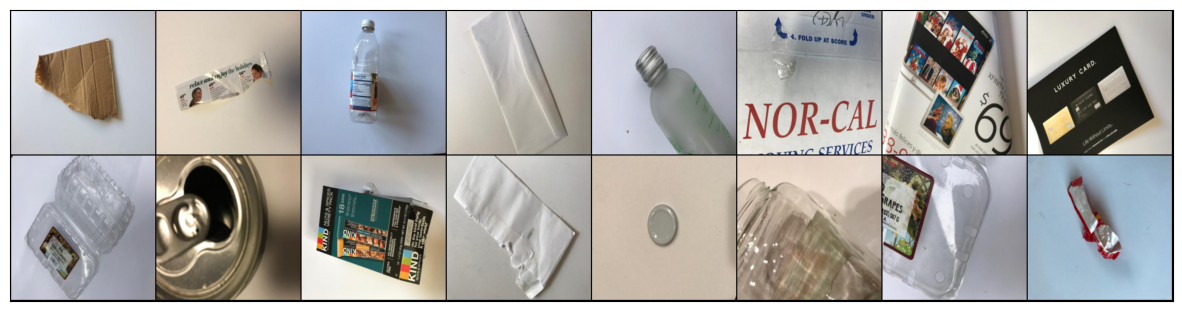

In [25]:
visualiza_batch(dl_treino)

## Modelagem

Modelos pré-treinados: https://pytorch.org/vision/main/models/resnet.html

### Definindo o Modelo Base

In [26]:
# Função para calcular a acurácia do modelo
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [27]:
# Modelo base
class ImageClassificationBase(nn.Module):

    # Construtor
    def __init__(self):
        super().__init__()
        self.history = None
        self.maxAcc = None
        self.evalAcc = None

    # Passo de treinamento
    def training_step(self, batch):

        # Batch
        images, labels = batch

        # Gera as previsões
        out = self(images)

        # Calcula o erro do modelo
        loss = F.cross_entropy(out, labels)

        return loss

    # Passo de validação
    def validation_step(self, batch):

        # Batch
        images, labels = batch

        # Gera as previsões
        out = self(images)

        # Calcula o erro
        loss = F.cross_entropy(out, labels)

        # Calcula a acurácia
        acc = accuracy(out, labels)

        return {'val_loss': loss.detach(), 'val_acc': acc}

    # Finaliza o passo de validação
    def validation_epoch_end(self, outputs):

        # Erro do batch
        batch_losses = [x['val_loss'] for x in outputs]

        # Erro da época
        epoch_loss = torch.stack(batch_losses).mean()

        # Acurácia de todos os batches e épocas
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # Print das métricas em cada batch
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

### Inicializando os Modelos ResNet

In [28]:
# Modelo ResNet18
class ResNet18(ImageClassificationBase):

    # Construtor
    def __init__(self):

        # Init do construtor da classe mãe
        super().__init__()

        # Carrega o modelo pré-treinado
        self.network = resnet18(weights = ResNet18_Weights.IMAGENET1K_V1)

        # Extrai o número de atributos
        num_ftrs = self.network.fc.in_features

        # Replace da última camada
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

        self.name = 'ResNet18'

    # Método forward
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [29]:
# Modelo ResNet152
class ResNet152(ImageClassificationBase):

    # Construtor
    def __init__(self):

        # Init do construtor da classe mãe
        super().__init__()

        # Carrega o modelo pré-treinado
        self.network = resnet152(weights = ResNet152_Weights.IMAGENET1K_V1)

        # Extrai o número de atributos
        num_ftrs = self.network.fc.in_features

        # Replace da última camada
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes)) # replace last layer

        self.name = 'ResNet152'

    # Método forward
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [30]:
# Inicializa os modelos
modelos = [ResNet18(), ResNet152()]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 75.3MB/s]


In [31]:
# Nomes dos modelos
nomes_modelos = [modelo.name for modelo in modelos]

In [32]:
print(nomes_modelos)

['ResNet18', 'ResNet152']


## Loop de Treinamento e Avaliação

In [33]:
# Define nenhum decorador de gradiente para o método de avaliação e define função para avaliação do modelo
@torch.no_grad()
def evaluate(model, val_loader):

    model.eval()

    # Coleta saídas para cada lote
    outputs = [model.validation_step(batch) for batch in val_loader]

    # Envia a saída completa para a função de modelo de fim de época
    return model.validation_epoch_end(outputs)

In [34]:
# Função para o treinamento
def fit(epochs, model, train_loader, val_loader, optimizer):

    # Histórico de treinamento
    history = []

    # Loop
    for epoch in range(epochs):

        # Chama o método de treinamento do modelo
        model.train()

        # Erros de. treino
        train_losses = []

        # Loop pelos batches do data loader
        for batch in train_loader:

            # Calcula o erro
            loss = model.training_step(batch)

            # Adiciona à lista de error
            train_losses.append(loss)

            # Backpropagation
            loss.backward()

            # Otimiza o modelo
            optimizer.step()

            # Não calcula gradiente para o batch
            optimizer.zero_grad()

        # Validação do modelo
        result = evaluate(model, val_loader)

        # Média de erro em treino
        result['train_loss'] = torch.stack(train_losses).mean().item()

        # Print do andamento das épocas
        model.epoch_end(epoch, result)

        # Histórico de treino
        history.append(result)

    return history

## Como Encontrar a Melhor Versão do Modelo?

In [35]:
# Função para encontrar o melhor modelo
def encontra_melhor_modelo(models):

    # Melhor modelo (maior acurácia)
    best_model = max([sum((model.maxAcc, model.evalAcc)) for model in models])

    return [model for model in models if sum((model.maxAcc,model.evalAcc)) == best_model][0]

In [36]:
# Função para executar a busca pelo melhor modelo
def busca_melhor_modelo(epochs, lr, models, train_loader, val_loader):

    # Lista para os resultados
    result_models = []

    # Intervalo entre cada execução para não aquecer muito o computador
    safety_sleep = 15

    # Loop
    for model in models:

        # Print
        print("\nIniciando o Treinamento do Modelo:", model.name)

        # Envia o modelo para o device
        model = to_device(model, device)

        # Define o otimizador
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Executa o método fit (treinamento)
        history = fit(epochs, model, train_loader, val_loader, optimizer)

        # Histórico de treinamento
        model.history = pd.DataFrame(history, columns = ['train_loss', 'val_loss', 'val_acc'])

        # Valor máximo de acurácia em validação
        model.maxAcc = max([x['val_acc'] for x in history])

        # Valor máximo de acurácia em teste
        model.evalAcc = evaluate(model, dl_teste)['val_acc']

        # Salva o resultado
        result_models.append(model)

        # Não precisa de sleep se for o último modelo
        if model.name != nomes_modelos[-1]:
            print(f'Descansando {safety_sleep} segundos')
            time.sleep(safety_sleep)
            safety_sleep += 5

    # Encontra o melhor modelo
    best_model = encontra_melhor_modelo(result_models)

    print("\nTreinamento Concluído!")

    return best_model, result_models

In [37]:
# Hiperparâmetros (número de épocas e taxa de aprendizado)
num_epochs = 5
taxa_aprendizado = 5.5e-5

In [38]:
%%time
melhor_modelo, resultados = busca_melhor_modelo(num_epochs, taxa_aprendizado, modelos, dl_treino, dl_valid)


Iniciando o Treinamento do Modelo: ResNet18
Epoch 1: train_loss: 1.3913, val_loss: 1.2176, val_acc: 0.8638
Epoch 2: train_loss: 1.1850, val_loss: 1.1646, val_acc: 0.8895
Epoch 3: train_loss: 1.1255, val_loss: 1.1317, val_acc: 0.9297
Epoch 4: train_loss: 1.0924, val_loss: 1.1302, val_acc: 0.9141
Epoch 5: train_loss: 1.0818, val_loss: 1.1272, val_acc: 0.9129


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Descansando 15 segundos

Iniciando o Treinamento do Modelo: ResNet152
Epoch 1: train_loss: 1.3187, val_loss: 1.1735, val_acc: 0.8728
Epoch 2: train_loss: 1.1362, val_loss: 1.1186, val_acc: 0.9129
Epoch 3: train_loss: 1.1010, val_loss: 1.1210, val_acc: 0.8973
Epoch 4: train_loss: 1.0830, val_loss: 1.1139, val_acc: 0.9375
Epoch 5: train_loss: 1.0789, val_loss: 1.1061, val_acc: 0.9353


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Treinamento Concluído!
CPU times: user 3min 10s, sys: 2min 11s, total: 5min 22s
Wall time: 9min 14s


## Salvando os Modelos em Disco

In [39]:
# Extrai os nomes dos modelo
nomes_modelos = [modelo.name for modelo in resultados]

In [40]:
# Pasta para salvar os modelos
pasta_modelos = Path('/content/drive/MyDrive/imagens/15-Projeto3/modelos/')

In [41]:
# Salva cada modelo com formato pickle
for i in range(len(nomes_modelos)):
    file = open(os.path.join(pasta_modelos, f'{nomes_modelos[i]}.pkl'), 'wb')
    pickle.dump(resultados[i], file)
    file.close()

## Carregando os Modelos do Disco

In [42]:
# Classe para carregar o modelo
class DeviceUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location = device)
        else: return super().find_class(module, name)

In [43]:
# Carrega cada modelo
loaded_models = []
for i in range(len(nomes_modelos)):
    file = open(os.path.join(pasta_modelos, f'{nomes_modelos[i]}.pkl'), 'rb')
    loaded_models.append(DeviceUnpickler(file).load())
    file.close()

In [44]:
# Melhor modelo
best_model = encontra_melhor_modelo(loaded_models)

In [45]:
best_model.name

'ResNet152'

## Avaliação do Modelo Através de Gráficos

In [46]:
# Plot
def plot_accuracies(history):
    accuracies = [acc for acc in history['val_acc']]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Acurácia')
    plt.title('Acurácia x Número de Épocas')

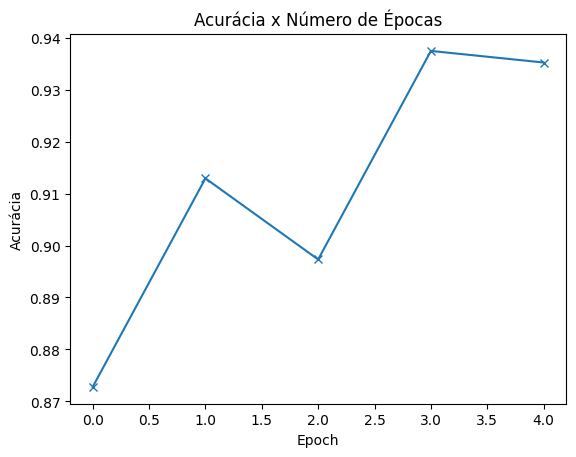

In [47]:
plot_accuracies(best_model.history)

In [48]:
# Plot
def plot_losses(history):
    train_losses = [x for x in history['train_loss']]
    val_losses = [x for x in history['val_loss']]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Erro')
    plt.legend(['Treinamento', 'Validação'])
    plt.title('Erro x Número de Épocas');

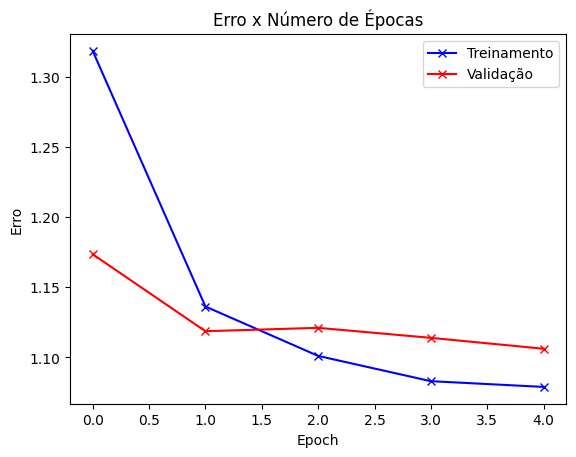

In [49]:
plot_losses(best_model.history)

In [50]:
# Coleta as acurácias de cada modelo
maxAccs = [model.maxAcc for model in loaded_models]
evalAccs = [model.evalAcc for model in loaded_models]

In [51]:
# Dataframe
acc_df = pd.DataFrame(zip(maxAccs,evalAccs), columns = ['maxAcc','evalAcc'], index = nomes_modelos)
acc_df['model_score'] = acc_df['maxAcc'] + acc_df['evalAcc']
acc_df

,maxAcc,evalAcc,model_score
ResNet18,0.929688,0.920759,1.850446
ResNet152,0.937500,0.920759,1.858259


## Previsões com Dados de Teste

In [52]:
# Função para as previsões
def previsao_imagem(img, model):

    # Batch de 1
    xb = to_device(img.unsqueeze(0), device)

    # Previsão
    yb = model(xb)

    # Índice da probabilidade mais alta
    prob, preds  = torch.max(yb, dim = 1)

    return dataset.classes[preds[0].item()]

Label: paper , Previsto: paper


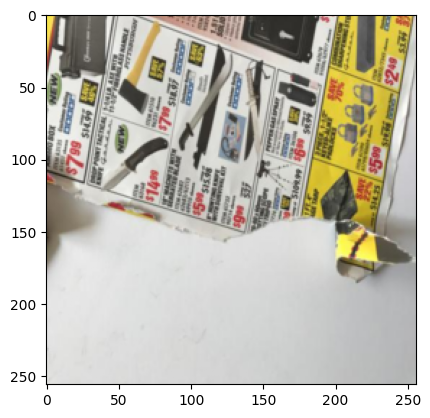

In [53]:
# Previsão
img, label = dados_teste[52]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Previsto:', previsao_imagem(img, best_model))

Label: metal , Previsto: metal


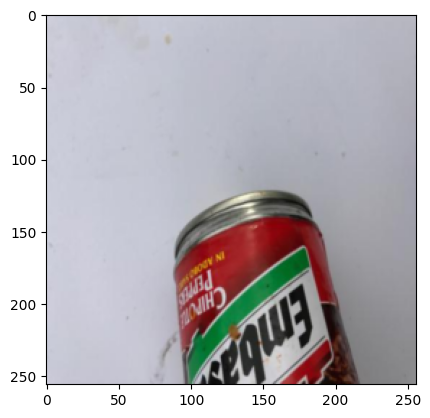

In [54]:
# Previsão
img, label = dados_teste[34]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Previsto:', previsao_imagem(img, best_model))

Label: paper , Previsto: paper


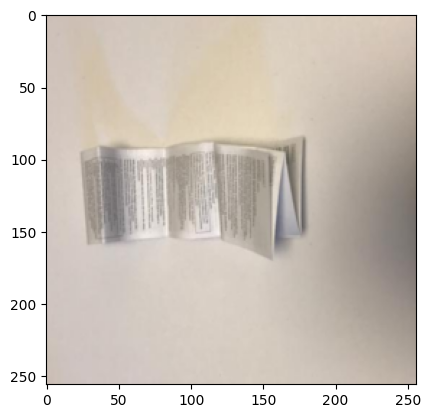

In [55]:
# Previsão
img, label = dados_teste[19]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Previsto:', previsao_imagem(img, best_model))

## Deploy e Uso do Modelo

In [56]:
# Pasta com novas imagens
img_dir = Path('/content/drive/MyDrive/imagens/15-Projeto3/novos_dados/')

In [57]:
# Caminho para cada nova imagem
imagem1 = os.path.join(img_dir, 'imagem1.jpg')
imagem2 = os.path.join(img_dir, 'imagem2.jpg')
imagem3 = os.path.join(img_dir, 'imagem3.jpg')
imagem4 = os.path.join(img_dir, 'imagem4.jpg')
imagem5 = os.path.join(img_dir, 'imagem5.jpg')
imagem6 = os.path.join(img_dir, 'imagem6.jpg')

In [58]:
# Download das imagens (se não existirem em disco)
if not os.path.exists(imagem1):
    urllib.request.urlretrieve("https://www.cargocabbie.ca/wp-content/uploads/2018/03/cargo-cabbie-shipping-box-12-x-9-x-6.jpg", imagem1)
if not os.path.exists(imagem2):
    urllib.request.urlretrieve("https://cdn.shopify.com/s/files/1/0669/3891/products/acc23b05-e02d-4a82-a113-5640d0fa634d_384x384.jpg?v=1634788809", imagem2)
if not os.path.exists(imagem3):
    urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.2F0uH6BguQMctAYEJ-s-1gHaHb%26pid%3DApi&f=1", imagem3)
if not os.path.exists(imagem4):
    urllib.request.urlretrieve("https://cdn.shopify.com/s/files/1/1722/0531/products/new-york-times-back-copies_1024x1024.jpg?v=1642632958", imagem4)
if not os.path.exists(imagem5):
    urllib.request.urlretrieve("https://discovery.sndimg.com/content/dam/images/discovery/fullset/2022/1/24/GettyImages-1325351577.jpg.rend.hgtvcom.406.406.suffix/1643047005309.jpeg", imagem5)
if not os.path.exists(imagem6):
    urllib.request.urlretrieve("https://livermorerecycles.org/wp-content/uploads/2018/04/bar-wrapper.jpg", imagem6)

In [59]:
# Função para as previsões
def classifica_imagem(img_path):

    # Carrega imagem
    image = Image.open(img_path)

    # Aplica mesma transformação aplicada antes do treino
    example_image = transformador(image)

    # Plot
    plt.imshow(example_image.permute(1, 2, 0))
    print("Previsão para a imagem:", previsao_imagem(example_image, best_model) + ".")

Previsão para a imagem: cardboard.


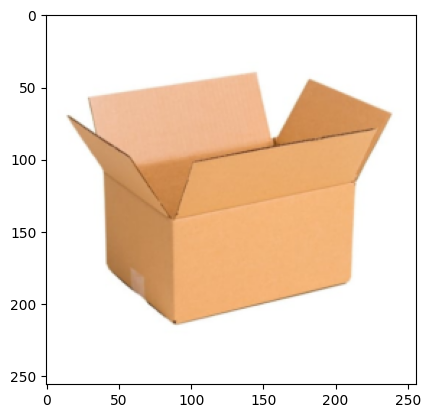

In [60]:
classifica_imagem(imagem1)

Previsão para a imagem: glass.


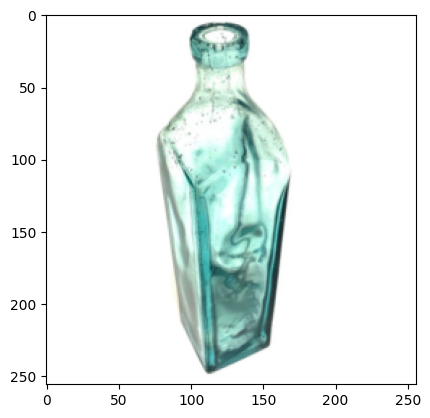

In [61]:
classifica_imagem(imagem2)

Previsão para a imagem: metal.


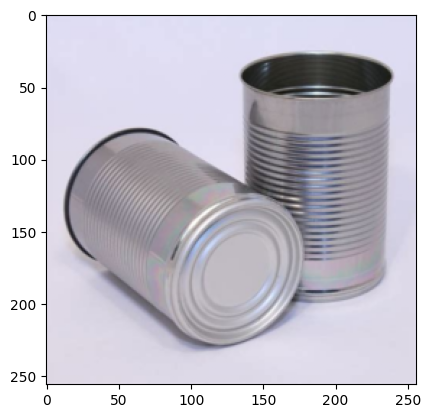

In [62]:
classifica_imagem(imagem3)

Previsão para a imagem: paper.


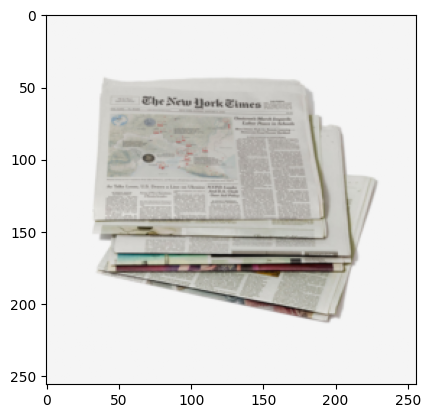

In [63]:
classifica_imagem(imagem4)

Previsão para a imagem: plastic.


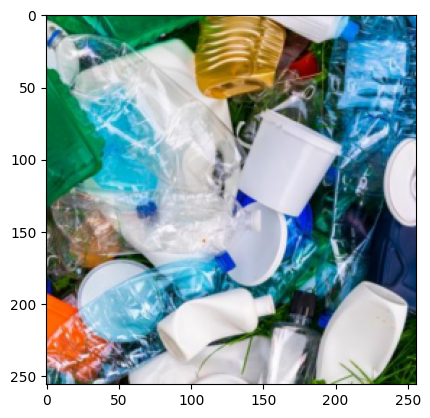

In [64]:
classifica_imagem(imagem5)

Previsão para a imagem: metal.


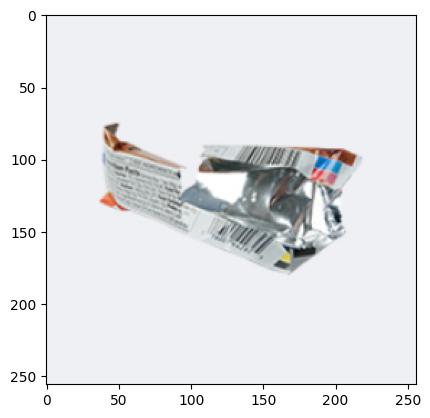

In [65]:
classifica_imagem(imagem6)

# Fim